In [31]:
import torch as tn
import torchtt as tntt
import TTCME
import matplotlib.pyplot as plt 
import datetime
import numpy as np
import pickle 

tn.set_default_tensor_type(tn.DoubleTensor)
qtt = True

In [32]:
r1m = TTCME.ChemicalReaction(['G','M','P','Gs'],'G->G+M', 'c1', params = ['c1'])
r2m = TTCME.ChemicalReaction(['G','M','P','Gs'],'M->M+P', 'c2', params = ['c2'])
r3m = TTCME.ChemicalReaction(['G','M','P','Gs'],'M->', 'c3', params = ['c3'])
r4m = TTCME.ChemicalReaction(['G','M','P','Gs'],'G+P->Gs', 'c4', params = ['c4'])
r5m = TTCME.ChemicalReaction(['G','M','P','Gs'],'Gs->G+P', 'c5', params = ['c5'])
r6m = TTCME.ChemicalReaction(['G','M','P','Gs'],'P->', 1.0, params = [])

mdl = TTCME.ReactionSystem(['G','M','P','Gs'], [r1m, r2m, r3m, r4m, r5m, r6m], params= ['c1','c2','c3','c4','c5'])

rates = np.array([4.0,10.0,1.0,0.2,0.6,1.0])
IC = [1, 0, 0, 0]
N = [4, 32, 128 ,4] # state truncation

In [33]:
with open(r"3stage2_45_500k.pickle", "rb") as input_file:
    dct = pickle.load(input_file) 

No = dct['time_observation'].size
time_observation = dct['time_observation']
reaction_time = dct['reaction_time']
reaction_jumps = dct['reaction_jumps']
reaction_indices = dct['reaction_indices']
observations = dct['observations']
observations_noise = dct['observations_noise']
dT = time_observation[1]-time_observation[0]
sigma = dct['sigma']
sample_posterior_mcmc = dct['sample']

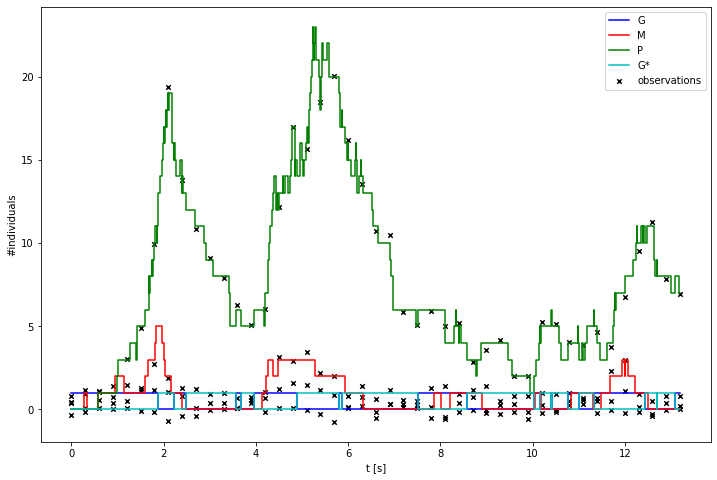

In [34]:
plt.figure(figsize = [12,8])
plt.plot(np.repeat(reaction_time,2)[1:],np.repeat(reaction_jumps[:,0],2)[:-1],'b')
plt.plot(np.repeat(reaction_time,2)[1:],np.repeat(reaction_jumps[:,1],2)[:-1],'r') 
plt.plot(np.repeat(reaction_time,2)[1:],np.repeat(reaction_jumps[:,2],2)[:-1],'g')
plt.plot(np.repeat(reaction_time,2)[1:],np.repeat(reaction_jumps[:,3],2)[:-1],'c') 
plt.scatter(time_observation,observations_noise[:,0],c='k',marker='x',s=20)
plt.scatter(time_observation,observations_noise[:,1],c='k',marker='x',s=20)
plt.scatter(time_observation,observations_noise[:,2],c='k',marker='x',s=20)
plt.scatter(time_observation,observations_noise[:,3],c='k',marker='x',s=20)
plt.xlabel('t [s]')
plt.ylabel('#individuals')
plt.legend(['G','M','P','G*','observations'])
import tikzplotlib
tikzplotlib.save('3stage_trajectory.tex')

In [35]:
Nl = 64
mult = 5
param_range = [[rc/1000,rc*mult] for rc in rates[:-1]]
basis_param = [TTCME.basis.BSplineBasis(Nl,[p[0],p[1]],deg = 2) for p in param_range]

In [36]:
mu = rates[:-1]*np.array([1.5,1.5,1.5,1.0,1.0])
var = rates[:-1] * np.array([4/3, 5, 0.25, 0.04, 0.2])
alpha_prior = mu**2/var
beta_prior = mu/var
prior = TTCME.GammaPDF(alpha_prior, beta_prior, basis_param, ['c1','c2','c3','c4','c5'])


In [37]:
p_ic = TTCME.pdf.SingularPMF(N,IC,['G','P','M','Gs'])
p0 = p_ic ** prior
p0.normalize()

p = p0.dofs.clone()

print(p0)

Probability density function:
p(G,P,M,Gs,c1,c2,c3,c4,c5)

Basis:
Dirac-deltas basis defined on {0, 3} and dimension 4
Dirac-deltas basis defined on {0, 31} and dimension 32
Dirac-deltas basis defined on {0, 127} and dimension 128
Dirac-deltas basis defined on {0, 3} and dimension 4
B-spline basis defined on [0.004, 20.0] and dimension 64
B-spline basis defined on [0.01, 50.0] and dimension 64
B-spline basis defined on [0.001, 5.0] and dimension 64
B-spline basis defined on [0.0002, 1.0] and dimension 64
B-spline basis defined on [0.0006, 3.0] and dimension 64

DoF:
TT with sizes and ranks:
N = [4, 32, 128, 4, 64, 64, 64, 64, 64]
R = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Device: cpu, dtype: torch.float64
#entries 488 compression 6.934897101018578e-12



In [38]:
obs_operator = TTCME.pdf.GaussianObservation(N, [sigma]*4)

In [39]:
Stt,Mtt,Mtt_inv = mdl.generator_tt_galerkin(N, basis_param)
Att = Mtt_inv @ Stt

In [40]:
if qtt:
    A_qtt = Att.to_qtt()
    fwd_int = TTCME.TimeIntegrator.TTInt(A_qtt, epsilon = 1e-5, N_max = 8, dt_max = 1.0,method='cheby')
    Nbs = 12
    p = p.to_qtt()
else:
    fwd_int = TTCME.TimeIntegrator.TTInt(Att, epsilon = 1e-5, N_max = 64, dt_max = 1.0,method='crank–nicolson')
    Nbs = 8

In [41]:
posterior_list  =[]
storage_joint = []
joint_pdf = p0.copy()
for i in range(1,No):
    
    y = observations_noise[i,:]

    
    po = obs_operator.likelihood(y) 
    #po = po / po.sum()
    
    po = po ** tntt.ones([Nl]*5)

    if qtt: po = po.to_qtt()

    
    print('new observation ',i,'/',No,' at time ',time_observation[i],' ',y)
    
    tme = datetime.datetime.now()
    p = fwd_int.solve(p, dT, intervals = Nbs,qtt = qtt,verb = False, rounding=True, device = None)
    tme = datetime.datetime.now() - tme
    
    
    print('\tmax rank ',max(p.R))
    p_pred = p
    p_post = po * p_pred
    p_post = p_post.round(1e-10)
    print('\tmax rank (after observation) ',max(p_post.R))
    
    storage_joint.append(tntt.numel(p_post)*8)

    if qtt:
        joint_pdf.dofs = tntt.reshape(p_post,joint_pdf.dofs.N)
        Z = joint_pdf.Z
        joint_pdf.normalize()
        p = p_post / Z
    else:
        joint_pdf.dofs = p_post.clone()
        joint_pdf.normalize()
        p = joint_pdf.dofs.clone()

    
    posterior_pdf = joint_pdf.marginal([0,1,2,3])
    posterior_pdf.round(1e-10)
    posterior_list.append(posterior_pdf.copy())



    E = posterior_pdf.expected_value()
    
    print('\tExpected value computed posterior ' ,E)
    # print('\tVariance computed posterior       ' ,V)
    print('\tposterior size ',tntt.numel(p)*8 / 1000000,' MB')
    print('\telapsed ',tme)

new observation  1 / 45  at time  0.3   [ 0.92455463  1.16993701 -0.15995999  0.1100867 ]
	max rank  175
	max rank (after observation)  103
	Expected value computed posterior  [tensor(5.5557), tensor(12.1605), tensor(1.5050), tensor(0.2000), tensor(0.5999)]
	posterior size  1.01192  MB
	elapsed  0:00:51.649629
new observation  2 / 45  at time  0.6   [1.04878591 1.11164833 0.55760128 0.07526628]
	max rank  236
	max rank (after observation)  146
	Expected value computed posterior  [tensor(4.9776), tensor(8.5266), tensor(1.5407), tensor(0.1990), tensor(0.6003)]
	posterior size  1.931552  MB
	elapsed  0:01:18.710596
new observation  3 / 45  at time  0.8999999999999999   [0.3972232  1.42170767 0.73433199 0.03160775]
	max rank  217
	max rank (after observation)  176
	Expected value computed posterior  [tensor(4.6127), tensor(6.3479), tensor(1.5506), tensor(0.1974), tensor(0.6011)]
	posterior size  2.4232  MB
	elapsed  0:01:08.146473
new observation  4 / 45  at time  1.2   [0.52693255 1.48130


Exact rates:                       [ 4.  10.   1.   0.2  0.6  1. ]

Expected value computed posterior  [tensor(4.0237), tensor(9.1566), tensor(1.8336), tensor(0.2369), tensor(1.0655)]
Variance computed posterior        [0.9502707  1.50833175 0.16711602 0.00514636 0.11599511]

Expected MCMC posterior            [4.05038771 9.199597   1.84430579 0.23793764 1.06802125]
Variance MCMC posterior            [0.97500681 1.52943509 0.17002805 0.00518616 0.12024642]

Relative absolute error exp        [0.66268413 0.46956481 0.58154183 0.43292697 0.24121458]  %
Relative absolute error var        [2.60306022 1.39911778 1.74252059 0.77327289 3.66507035]  %

Expected value prior               [ 6.  15.   1.5  0.2  0.6]
Variance computed prior            [5.33333333e+00 5.00000000e+01 2.50000000e-01 8.00000000e-03
 1.20000000e-01]

Posterior at the end 8.008192
Generator in TT 11.016832 MB
Generator in QTT 0.195968 MB
Max storage joint in QTT 10.325968


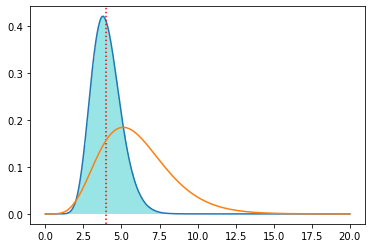

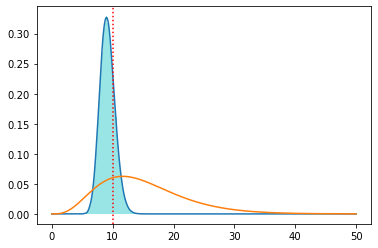

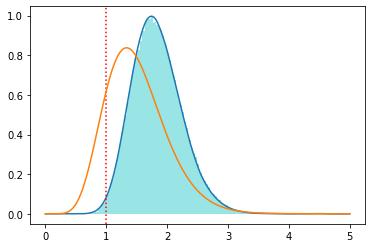

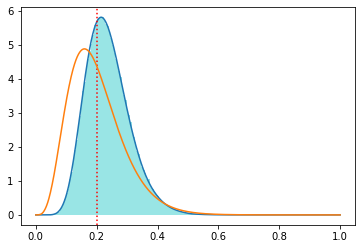

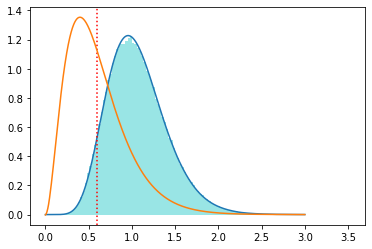

In [42]:
posterior_pdf.normalize()
nburn = 150000

E = posterior_pdf.expected_value()
C = posterior_pdf.covariance_matrix()
V = np.diag(C)

print()
print('Exact rates:                      ',rates)
print('')
print('Expected value computed posterior ' ,E)
print('Variance computed posterior       ' ,V)
# print('Computed modes:                   ',theta_mode)
print('')
print('Expected MCMC posterior           ' ,np.mean(sample_posterior_mcmc[nburn:,:],0))
print('Variance MCMC posterior           ' ,np.std(sample_posterior_mcmc[nburn:,:],0)**2)
print('')
print('Relative absolute error exp       ',np.abs(np.mean(sample_posterior_mcmc[nburn:,:],0)-E)/E * 100,' %')
print('Relative absolute error var       ',np.abs(np.std(sample_posterior_mcmc[nburn:,:],0)**2-V)/V * 100,' %')
print('')
print('Expected value prior              ' ,alpha_prior/beta_prior)
print('Variance computed prior           ' ,alpha_prior/beta_prior/beta_prior)
print('')

print('Posterior at the end',tntt.numel(posterior_list[-1].dofs)*8/1e6)
print('Generator in TT', tntt.numel(Att)*8/1e6, 'MB')
print('Generator in QTT', tntt.numel(A_qtt)*8/1e6, 'MB')
print('Max storage joint in QTT',max(storage_joint)/1e6)

post_1 = posterior_pdf.marginal([1,2,3,4])
post_2 = posterior_pdf.marginal([0,2,3,4])
post_3 = posterior_pdf.marginal([0,1,3,4])
post_4 = posterior_pdf.marginal([0,1,2,4])
post_5 = posterior_pdf.marginal([0,1,2,3])

for i in range(5):
    pr = prior.marginal([j for j in range(5) if i!=j])
    po = posterior_pdf.marginal([j for j in range(5) if i!=j])
    x = np.linspace(param_range[i][0],param_range[i][1],1000)
    
    
    plt.figure()
    plt.plot(x, po[x].numpy())
    plt.hist(sample_posterior_mcmc[nburn:,i],bins=128,density=True,color='c',alpha=0.4)
    plt.axvline(rates[i],c='r',linestyle=':')
    plt.plot(x, pr[x].numpy())

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


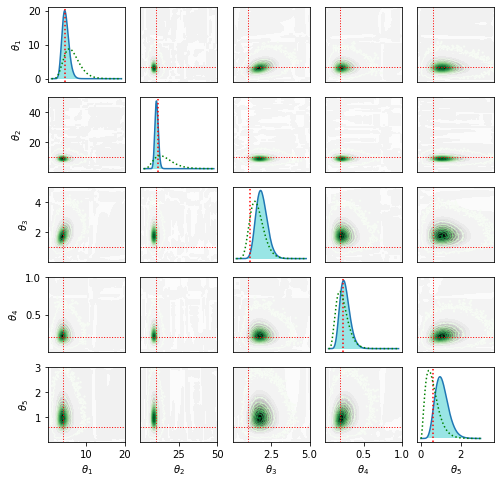

In [43]:
plt.figure(figsize = [8,8])
import tikzplotlib
k = 0
for i in range(5):
    for j in range(5):
        k += 1
        if i==j:
            plt.subplot(5, 5, k)
            
            theta = np.linspace(param_range[i][0],param_range[i][1],1000)
            pr = prior.marginal([k for k in range(5) if i!=k])[theta].numpy()
            po = posterior_pdf.marginal([k for k in range(5) if i!=k])[theta].numpy()
           
            plt.plot(theta,po/np.max(po)*np.max(theta))
            count, bins = np.histogram(sample_posterior_mcmc[nburn:,i],bins=128,density=True)
            count = count/np.max(po)*np.max(theta)
            plt.hist(bins[:-1], bins, weights=count,color='c',alpha=0.4)
            plt.axvline(rates[i],c='r',linestyle=':')
            plt.plot(theta,pr/np.max(po)*np.max(theta),'g:')
            
        else:
            plt.subplot(5, 5, k)
             
            if j<i: 
                theta1 = np.linspace(param_range[j][0],param_range[j][1],127)
                theta2 = np.linspace(param_range[i][0],param_range[i][1],128)
                
                T1, T2 = np.meshgrid(theta1, theta2)
                po = posterior_pdf.marginal([k for k in range(5) if i!=k and j!=k])
                po.normalize()
                po = po[theta1,theta2].numpy().T

                counts,ybins,xbins,image = plt.hist2d(sample_posterior_mcmc[nburn:,j],sample_posterior_mcmc[nburn:,i],bins=100,density = True, range =[[T1.min(), T1.max()],[T2.min(), T2.max()]])
                plt.contour(counts.T,extent=[T1.min(), T1.max(), T2.min(), T2.max()],linewidths=1,levels=10, cmap =plt.cm.Greens)

                plt.contourf(T1, T2, po, cmap='gray_r', levels =32)
                plt.axvline(rates[j],c='r',linestyle=':',linewidth=1)
                plt.axhline(rates[i],c='r',linestyle=':',linewidth=1)
            else: 
                theta1 = np.linspace(param_range[i][0],param_range[i][1],127)
                theta2 = np.linspace(param_range[j][0],param_range[j][1],128)
                
                T1, T2 = np.meshgrid(theta1, theta2)
                po = posterior_pdf.marginal([k for k in range(5) if i!=k and j!=k])
                po.normalize()
                po = po[theta1,theta2].numpy().T

                counts,ybins,xbins,image = plt.hist2d(sample_posterior_mcmc[nburn:,j],sample_posterior_mcmc[nburn:,i],bins=100,density = True, range =[[T2.min(), T2.max()],[T1.min(), T1.max()]])
                plt.contour(counts.T,extent=[T2.min(), T2.max(), T1.min(), T1.max()],linewidths=1,levels=10, cmap =plt.cm.Greens)

                plt.contourf(T2, T1, po, cmap='gray_r', levels =32)
                plt.axvline(rates[j],c='r',linestyle=':',linewidth=1)
                plt.axhline(rates[i],c='r',linestyle=':',linewidth=1)
        
        if i==4: plt.xlabel(r'$\theta_'+str(j+1)+'$')
        if j==0: plt.ylabel(r'$\theta_'+str(i+1)+'$')
        
        if j>0: plt.yticks([])
        if i<4: plt.xticks([])
plt.savefig('3stage_post.eps')
tikzplotlib.save('./3stage_post.tex')

In [46]:
print('Posterior at the end',tntt.numel(posterior_list[-1].dofs)*8/1e6)
print('Generator in TT', tntt.numel(Att)*8/1e6, 'MB')
print('Generator in QTT', tntt.numel(A_qtt)*8/1e6, 'MB')
print(posterior_list[-1])

Posterior at the end 8.008192
Generator in TT 11.016832 MB
Generator in QTT 0.195968 MB
Probability density function:
p(c1,c2,c3,c4,c5)

Basis:
B-spline basis defined on [0.004, 20.0] and dimension 64
B-spline basis defined on [0.01, 50.0] and dimension 64
B-spline basis defined on [0.001, 5.0] and dimension 64
B-spline basis defined on [0.0002, 1.0] and dimension 64
B-spline basis defined on [0.0006, 3.0] and dimension 64

DoF:
TT with sizes and ranks:
N = [64, 64, 64, 64, 64]
R = [1, 54, 126, 58, 25, 1]

Device: cpu, dtype: torch.float64
#entries 1001024 compression 0.0009322762489318848

